<a href="https://colab.research.google.com/github/ssuzana/Machine-Learning-Notebooks/blob/main/Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* A Support Vector Machine (SVM) is a powerful and versatile Machine Learning model, capable of performing linear and nonlinear classification, regression, and even outlier detection. 

* SVMs are particularly well suited for classification of complex small- or medium-sized datasets.

* Note that SVMs are sensitive to feature scales. Feature scaling can be done using Scikit-Learn's `StandardScaler`.

In [ ]:
# create the images/svm folder (if it doesn't already exist),
# and define the save_fig() function which is used through this notebook to save the figures in high-res 
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear SVM Classification

* You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines in the picture below) between the classes.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear")
svm_clf.fit(X, y)

SVC(kernel='linear')

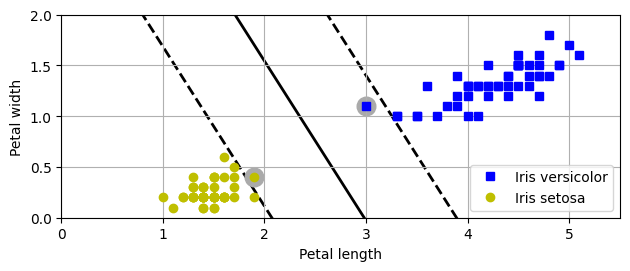

In [ ]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

save_fig("large_margin_classification_plot")
plt.show()

## Soft Margin Classification

* If we strictly impose that all instances must be off the "street" and on the correct side, this is called *hard margin classification*.

* Two main issues: 
  * it only works if the data is linearly separable, and
  * it is sensitive to outliers (the model will probably not generalize as well).

*  Objective: find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called *soft margin classification*.

* When creating an SVM model using Scikit-Learn, you can specify several hyperpara‐meters, including the regularization hyperparameter $C$. 

* Reducing the regularization hyperparameter $C$ makes the "street" larger, but it also leads to more margin violations. In other words, reducing $C$ results in more instances supporting the street, so there’s less risk of overfitting. But if you reduce it too much, then the model ends up underfitting.



In [ ]:
# load the iris dataset and train a linear SVM classifier
# to detect Iris virginica flowers
# first scale the features, then use a LinearSVC with C=100
# you can change the value of C and see the new plot
# C=100 looks like it will generalize better than the one with C=1

from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2) # Iris virginica

scaler = StandardScaler()
svm_clf = LinearSVC(C=100, max_iter=10_000, random_state=42)
scaled_svm_clf = make_pipeline(scaler,svm_clf)
scaled_svm_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=100, max_iter=10000, random_state=42))])

In [ ]:
# Convert to unscaled parameters
b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])
w = svm_clf.coef_[0] / scaler.scale_
svm_clf.intercept_ = np.array([b])
svm_clf.coef_ = np.array([w])

In [ ]:
# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx = (t * (X.dot(w) + b) < 1).ravel()
svm_clf.support_vectors_ = X[support_vectors_idx]

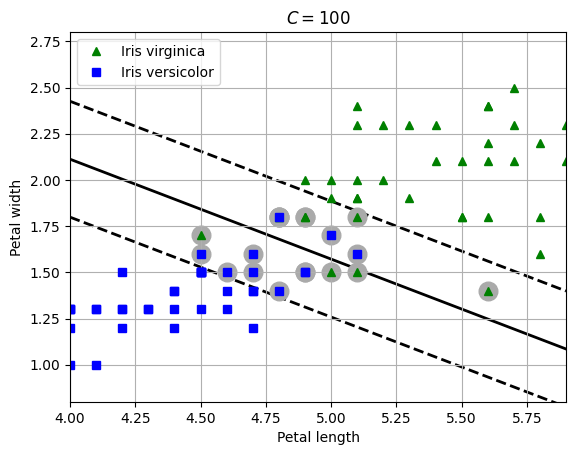

In [ ]:
# plot the resulting model
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

In [ ]:
# use the model to make predictions
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

The first plant is classified as an Iris virginica, while the second is not. 

In [ ]:
# look at the scores that the SVM used to make these predictions
# these measure the signed distance between each instance and the decision boundary
svm_clf.decision_function(X_new)

array([ 1.27064556, -0.22915795])

* Unlike `LogisticRegression`, `LinearSVC` doesn’t have a `predict_proba()` method to estimate the class probabilities.  

* If you use the `SVC` class  instead of `LinearSVC`, and if you set its probability hyperparameter to `True`, then the model will fit an extra model at the end of training to map the `SVM` decision function scores to estimated probabilities. 

* Under the hood, this requires using 5-fold cross-validation to generate out-of-sample predictions for every instance in the training set, then training a `LogisticRegression` model, so it will slow down training considerably. After that, the `predict_proba()` and `predict_log_proba()` methods will be available.

# Under the Hood of Linear SVM Classifiers

* The linear SVM classifier model predicts the class of a new instance $\mathbf{x}$ by simply computing the decision function $h(\mathbf{x})=\mathbf{w}^\top \mathbf{x} + b = w_1 x_1 + \ldots w_n x_n + b$:

  * If the result is positive, the predicted class $\widehat{y}$ is the positive class (1).
  * Otherwise, it is the negative class (0).

* Linear SVM classifier prediction:
  $$\widehat{y} = \begin{cases} 0 & \text{if } \mathbf{w}^\top \mathbf{x} + b < 0 \\
 1 & \text{if } \mathbf{w}^\top \mathbf{x} + b \geq 0 \end{cases} $$  

* The decision boundary is the set of points where the decision function $h(\mathbf{x})=\mathbf{w}^\top \mathbf{x} + b$ is equal to zero. 

* If the dataset has two features, the decision boundary is the intersection of two planes, which is a straight line (represented by the thick solid line in our iris dataset example). The dashed lines are parallel and at equal distance to the decision boundary, and they form a margin around it.

* Training a linear SVM classifier means finding the values of $\mathbf{w}$ and $b$ the margin/"street" as wide as possible while  limiting the number of margin violations:

   * To make the margin larger, we need to make $\mathbf{w}$ smaller. 

   Let’s look at a 2D example. We define the borders of the street as the points where the decision function is equal to $-1$ or $+1$. If we set the weight $w_1$ to be 1, the points at which $w_1 x_1 = -1$ or $+1$ are $x_1 = -1$ and $+1$: therefore the margin’s size is 2. If we set the weight to be 0.5, the points at which $w_1 x_1 = -1$ or $+1$ are $x_1 = -2$ and $+2$: the margin’s size is 4.
   * Note that the bias term $b$ has no influence on the size of the margin: tweaking it just shifts the margin around, without affecting its size.

   * To avoid margin violations, we need the decision function to be greater than 1 for all positive training instances and lower than –1 for negative training instances. 

  * If we define $t^{(i)} = -1$ for negative instances (when $y^{(i)} = 0$) and $t^{(i)} = 1$ for positive instances (when $y^{(i)} = 1$), then we can write this constraint as 
$$ t^{(i)}(\mathbf{w}^\top \mathbf{x}^{(i)} + b) ≥ 1$$ for all instances.






## Hard margin linear SVM classifier objective

* We can express the hard margin linear SVM classifier objective as the constrained optimization problem:

$$\underset{\mathbf{w},b}{\mathrm{minimize} }\ \frac{1}{2} \mathbf{w}^\top \mathbf{w}$$
$$\mathrm{subject\ to} \ t^{(i)}\left(\mathbf{w}^\top \mathbf{x}^{(i)}+ b \right) \geq 1 \text{ for } i= 1,2,\ldots, m$$

* Note that we are minimizing $\frac{1}{2} \mathbf{w}^\top \mathbf{w}$, which is equal to $\frac{1}{2}||\mathbf{w}||^2$, rather than minimizing $||\mathbf{w}||$. Indeed, $\frac{1}{2} \mathbf{w}^\top \mathbf{w}$ has a nice, simple derivative (it is just $\mathbf{w})$, while $||\mathbf{w}||$ is not differentiable at $\mathbf{w} = 0$. Optimization algorithms often work much better on differentiable functions.

## Soft margin linear SVM classifier objective

* To get the soft margin objective, we need to introduce a slack variable $\zeta^{(i)} \geq 0$ for each instance: 

 $\zeta^{(i)}$ measures how much the $i$th instance is allowed to violate the margin. 
 
* We now have two conflicting objectives: make the slack variables as small as possible to reduce the margin violations, and make $\frac{1}{2} \mathbf{w}^\top \mathbf{w}$ as small as possible to increase the margin. 

 This is where the $C$ hyperparameter comes in: it allows us to define the trade-off between these two objectives. 
 
 This gives us the following constrained optimization:

$$\underset{\mathbf{w},b, \zeta}{\mathrm{minimize} }\ \frac{1}{2} \mathbf{w}^\top \mathbf{w} + C\sum_{i=1}^m \zeta^{(i)}$$
$$\mathrm{subject\ to} \ t^{(i)}\left(\mathbf{w}^\top \mathbf{x}^{(i)}+ b \right) \geq 1 - \zeta^{(i)} \text{ and } \zeta^{(i)}\geq 0 \text{ for } i= 1,2,\ldots, m$$


* If a large value of $C$ is chosen, the penalty for misclassification becomes relatively high. This means the model might be prone to overfitting, since few mistakes are allowed during training. An SVM model with a large $C$ has a low bias, but it might suffer from high variance.

* Conversely, if the value of $C$ is sufficiently small, the influence of misclassification becomes fairly low. This model allows more misclassified data points than a model with a large $C$. Thus, data separation becomes less strict. Such a model has low variance, but it might be compromised by high bias.

## Hinge loss and squared hinge loss 

* The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as *quadratic programming* (QP) problems. Using a QP solver is one way to train an SVM.

* Another is to use gradient descent to minimize the *hinge loss* or the *squared hinge loss*.

$$ \text{Hinge loss } = \max (0, 1-st) \text{ where } s = \mathbf{w}^\top \mathbf{x} + b$$



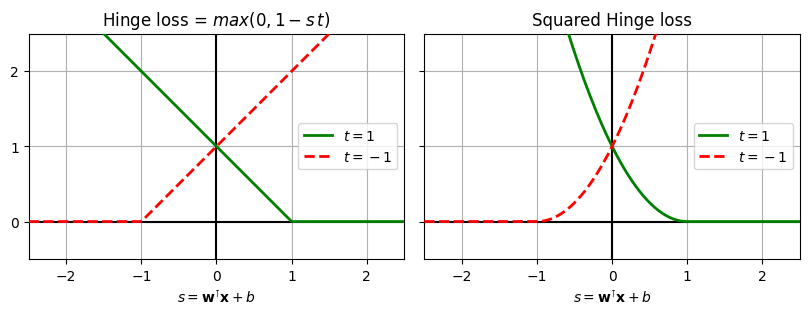

In [ ]:
s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", "Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

save_fig("hinge_plot")
plt.show()

* Given an instance $\mathbf{x}$ of the positive class (i.e., with $t = 1$, the loss is 0 if the output $s$ of the decision function ($s = \mathbf{w}^\top \mathbf{x} + b$) is greater than or equal to 1. 

 This happens when the instance is off the street and on the positive side. 
 
* Given an instance of the negative class (i.e., with $t = -1$), the loss is 0 if $s \leq -1$. 

 This happens when the instance is off the street and on the negative side. 
 
* The further away an instance is from the correct side of the margin, the higher the loss: it grows linearly for the hinge loss, and quadratically for the squared hinge loss. 

 This makes the squared hinge loss more sensitive to outliers. However, if the dataset is clean, it tends to converge faster. 

* By default, `LinearSVC` uses the squared hinge loss, while `SGDClassifier` uses the hinge loss. Both classes let you choose the loss by setting the `loss` hyperparameter to `"hinge"` or `"squared_hinge"`.

# Example using scikit-learn SVC

See https://scikit-learn.org/stable/modules/svm.html#svc.

We will use the breast cancer Wisconsin dataset from scikit-learn.

See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html.


In [7]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer(as_frame=True)

In [19]:
cancer_data.data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [27]:
X = cancer_data.data
Y = cancer_data.target

In [28]:
print('Input data size:', X.shape)
print('Output data size :', Y.shape)
print('Label names:', cancer_data.target_names)
print(f'{(Y == 1).sum()} positive samples and {(Y == 0).sum()} negative samples.')

Input data size: (569, 30)
Output data size : (569,)
Label names: ['malignant' 'benign']
357 positive samples and 212 negative samples.


In [30]:
from sklearn.model_selection import train_test_split
# for reproducibility, we specify a random seed
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [34]:
from sklearn.svm import SVC
# the penalty hyperparameter C set to the default value, 1.0
clf = SVC(kernel='linear', C=1.0, random_state=42)

In [35]:
clf.fit(X_train, Y_train)

SVC(kernel='linear', random_state=42)

In [36]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 95.8%


# Nonlinear SVM Classification

* Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. 

* One approach to handling nonlinear datasets: add more features, such as polynomial features. In some cases this can result in a linearly separable dataset.

* Scikit-Learn implementation: create a `Pipeline` containing a `PolynomialFeatures` transformer, followed by a `StandardScaler` and a `LinearSVC`.

* Moons dataset: toy dataset for binary classification in which data points are shaped as two interleaving circles. This dataset can be generated using the `make_moons()` function.

In [ ]:
from sklearn.datasets import make_moons 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

poly_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
poly_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

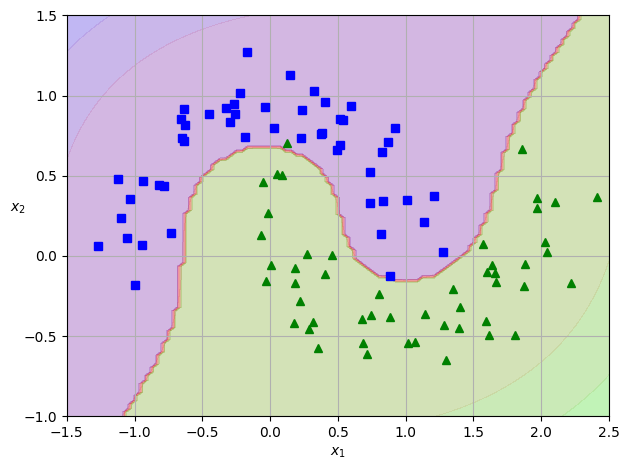

In [ ]:
# make plot
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(poly_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## Polynomial Kernel

When using SVMs you can apply a mathematical technique called the *kernel trick* which makes it possible to get the same result as if you added many polynomial features, without actually having to add them.



In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

# References

* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, by Aurélien Géron.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)
* [Python Machine Learning By Example - Third Edition, by Yuxi (Hayden) Liu](https://www.packtpub.com/product/python-machine-learning-by-example-third-edition/9781800209718)